#### 1.1. Load the dataset which are in three folders, namely train, validation, and test

In [1]:
import matplotlib.pyplot as plt
from collections import OrderedDict

from copy import deepcopy
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

# download the data and unzip it. You should have three sets of data
data_dir = 'nail_diseases'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
# test_dir = data_dir + '/test'




#### 1.3. Data transformation and processing

In [2]:
# Process with some data transformation, do not change
data_transforms = {
    'training': transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224,
                                                          0.225])]),

    'validation': transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(
                                          [0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]),

    # 'testing': transforms.Compose([transforms.Resize(256),
    #                                transforms.CenterCrop(224),
    #                                transforms.ToTensor(),
    #                                transforms.Normalize([0.485, 0.456, 0.406],
    #                                                     [0.229, 0.224,
    #                                                      0.225])])
}
# This specifies how many images to process per training/validation
batch_size = 256

image_datasets = {
    'training': datasets.ImageFolder(train_dir,
                                     transform=data_transforms['training']),
    # 'testing': datasets.ImageFolder(test_dir,
    #                                 transform=data_transforms['testing']),
    'validation': datasets.ImageFolder(valid_dir,
                                       transform=data_transforms['validation'])
}

dataloaders = {
    'training': torch.utils.data.DataLoader(image_datasets['training'],
                                            batch_size=batch_size,
                                            shuffle=True),
    # 'testing': torch.utils.data.DataLoader(image_datasets['testing'],
    #                                        batch_size=batch_size,
    #                                        shuffle=False),
    'validation': torch.utils.data.DataLoader(image_datasets['validation'],
                                              batch_size=batch_size,
                                              shuffle=True)
}

# get the length of each dataloaders; wit batch size=256, you should have 26 batches of training samples, each with 256 images 
training_len = len(dataloaders['training'])
# test_len = len(dataloaders['testing'])
validation_len = len(dataloaders['validation'])
class_to_idx = image_datasets['training'].class_to_idx

print('We have ', training_len, 'batches of training images;', 'each with',
      batch_size, 'images')
print('We have ', validation_len, 'batches of validation images;', 'each with',
      batch_size, 'images')

# Let us preview size of each batch
print('Single batch', next(iter(dataloaders['training']))[0].shape)

We have  15 batches of training images; each with 256 images
We have  1 batches of validation images; each with 256 images
Single batch torch.Size([256, 3, 224, 224])


#### 1.4. Initialize the pretrained model

We are going to use an Alexnet convolutional neural network as our pretrained model. The architecture of the network is shown in 

 https://bouzouitina-hamdi.medium.com/alexnet-imagenet-classification-with-deep-convolutional-neural-networks-d0210289746b

In [3]:
# Transfer learning with alexnet
model = models.alexnet(pretrained=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 1.5. Update the classifier of the model to be compatible with our datasets

In [4]:
# In transfer learning, we freeze the feature parameters from the original model
# The most straightforward way is to freeze their gradient update
# see https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html for how to set it
for param in model.parameters():
    param.requires_grad = False

print(model)

# This is the original classifier with alexnet
print()
print('Original classifier of Alexnet')
print(model.classifier)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [5]:
# now we need to replace the classifier by our datasets
# Note, fc2's out_feature should match our number of classes, which is 102

# Tip: check the original AlexNet classifier for some thoughts; they are similar.

# Defining number of hidden units in our fully connected layer
hidden_units = 4096
number_of_nail_diseases = len(class_to_idx)

# Defining the fully connected layer that will be trained on the flower images
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(9216, hidden_units)), # this should be a Linear layer; how should it be connected to the pretrained model?
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.5)),
    ('fc2', nn.Linear(hidden_units, number_of_nail_diseases)), # what should be the output of this layer?
    ('output', nn.LogSoftmax(dim=1))
]))


In [6]:
# double check if the classifier of the model is updated.
model.classifier = classifier
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (fc1): Linear(in_features=9216, out_features=4096, bias=True)
    (relu): ReLU()
    (dropout): Drop

### 1.6. Set up the configurations and train it!
- epochs = 30
- since it is a multiclassification problem, we use [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)
- we use the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
- learning rate (lr) = 0.001

In each epoch, we go through all the training samples to update the model, and evaluate with the validation samples to see how good the current model is.
- accuracy: mean of the matches in predicted class and the labels
- loss: negative log likelihood loss


**Sample outputs are provided below; but yours may vary**
**Your validation accuracy may be better than train; this is fine**

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 30
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
criterion = nn.NLLLoss() # this is the loss
print_every = 5

validation_accuracies, training_accuracies = [], []
validation_losses, training_losses = [], []

best_validation_accuracy = 0
best_model_weights = None

for e in range(epochs):

    training_loss = training_accuracy = 0
    validation_loss = validation_accuracy = 0

    model.train()
    for batch_idx, (images, labels) in enumerate(dataloaders['training']):

        # Moving images & labels to the GPU if there is one
        images, labels = images.to(device), labels.to(device)

        # Pushing batch through network, calculating loss & gradient, and updating weights
        log_ps = model.forward(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()

        # Calculating metrics
        ps = torch.exp(log_ps)
        top_ps, top_class = ps.topk(1, dim=1)
        matches = (top_class == labels.view(*top_class.shape)).type(
            torch.FloatTensor)
        train_batch_accuracy = matches.mean()

        # Resetting optimizer gradient & tracking metrics
        optimizer.zero_grad()
        training_loss += loss.item()
        train_batch_loss = loss.item()
        training_accuracy += train_batch_accuracy.item()

        if batch_idx % print_every == 0:
            # First analyze the training statistics
            print('epoch', e, 'batch', batch_idx)
            print('training loss per batch', train_batch_loss)
            print('training accuracy per batch', train_batch_accuracy.item())

    # Then do the analysis for the validation only at the end of each training epochs
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(
                dataloaders['validation']):
            images, labels = images.to(device), labels.to(device)
            log_ps = model(images)
            loss = criterion(log_ps, labels)
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(
                torch.FloatTensor)
            validation_batch_accuracy = matches.mean()

            # Tracking validation metrics
            validation_loss += loss.item()
            validation_batch_loss = loss.item()
            validation_accuracy += validation_batch_accuracy.item()

    # Save the best model weights so far
    # Tip: see this https://pytorch.org/tutorials/beginner/saving_loading_models.html
    if validation_accuracy >= best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_model_weights = model.state_dict()

    # Summary statistic per epoch
    print('epoch', e, 'summary')
    print('avg training loss per epoch', training_loss / training_len)
    print('avg training accuracy per epoch', training_accuracy / training_len)
    training_losses.append(training_loss / training_len)
    training_accuracies.append(training_accuracy / training_len)

    print('avg validation loss per epoch', validation_loss / validation_len)
    print('avg validation accuracy per epoch',
          validation_accuracy / validation_len)
    validation_losses.append(validation_loss / validation_len)
    validation_accuracies.append(validation_accuracy / validation_len)

    print()

epoch 0 batch 0
training loss per batch 1.7919549942016602
training accuracy per batch 0.16796875
epoch 0 batch 5
training loss per batch 15.714024543762207
training accuracy per batch 0.26953125
epoch 0 batch 10
training loss per batch 3.3624258041381836
training accuracy per batch 0.375
epoch 0 summary
avg training loss per epoch 7.812909928957621
avg training accuracy per epoch 0.33671875
avg validation loss per epoch 1.4524601697921753
avg validation accuracy per epoch 0.4615384638309479

epoch 1 batch 0
training loss per batch 1.6751905679702759
training accuracy per batch 0.41015625
epoch 1 batch 5
training loss per batch 1.0623899698257446
training accuracy per batch 0.5625
epoch 1 batch 10
training loss per batch 1.0163289308547974
training accuracy per batch 0.60546875
epoch 1 summary
avg training loss per epoch 1.1809701959292094
avg training accuracy per epoch 0.5335416674613953
avg validation loss per epoch 0.7000277042388916
avg validation accuracy per epoch 0.747252762317

In [8]:
print('Best Validation Accuracy:', best_validation_accuracy / validation_len)

Best Validation Accuracy: 0.901098906993866


### 1.7. Draw learning curves

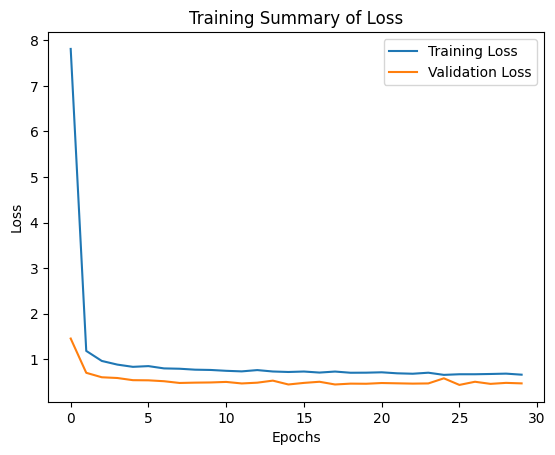

In [9]:
plt.figure()
plt.title("Training Summary of Loss")
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

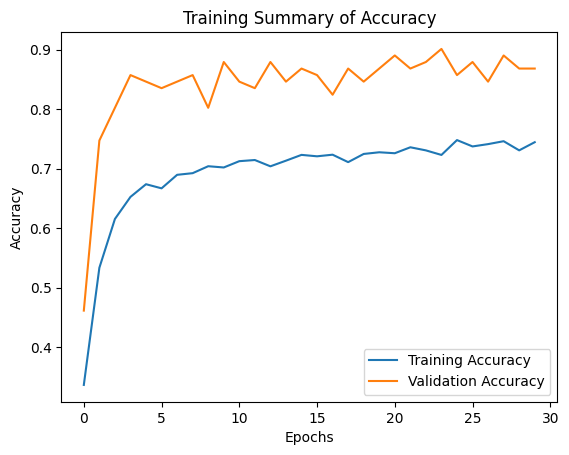

In [10]:
plt.figure()
plt.title("Training Summary of Accuracy")
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 1.8. Predict on the test data with the best model so far

### Grad-CAM Visualization
We compute class-discriminative localization maps using the gradients of the target class flowing into the last convolutional layer (`features[12]`). The map highlights spatial regions most influential for the prediction.

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.models as models

# Grad-CAM storage
gradcam_activations = {}
gradcam_gradients = {}

# Target layer: last convolution layer in AlexNet
target_layer = model.features[12]

# Forward hook: save activations (feature maps) and register a tensor-level grad hook
def _forward_hook(module, inp, out):
    # Save detached activations for CAM computation
    gradcam_activations['value'] = out.detach()  # shape: (N,C,H,W)
    # Register a gradient hook on the tensor output to capture dL/d(activations)
    def _tensor_grad_hook(grad):
        gradcam_gradients['value'] = grad.detach()  # shape: (N,C,H,W)
    out.register_hook(_tensor_grad_hook)

# Register hooks
# Remove existing handles if this cell is re-run
try:
    forward_handle.remove()
except Exception:
    pass
try:
    backward_handle.remove()  # in case an old backward handle existed from previous attempts
except Exception:
    pass

forward_handle = target_layer.register_forward_hook(_forward_hook)


def generate_gradcam(model, image_tensor, device, class_index=None):
    """
    Compute Grad-CAM for a single image tensor of shape (1,3,224,224).
    If class_index is None, uses the model's top predicted class.
    Returns (heatmap, class_index) where heatmap is (H,W) in [0,1].
    """
    model.eval()
    gradcam_activations.clear()
    gradcam_gradients.clear()

    # Ensure gradients are enabled for this pass (even if model params are frozen)
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad_(True)

    # Forward
    with torch.enable_grad():
        output = model(image_tensor)  # log-probabilities from final LogSoftmax
        if class_index is None:
            class_index = int(output.argmax(dim=1).item())
        target_score = output[0, class_index]

    # Backward to get gradients at target layer
    model.zero_grad(set_to_none=True)
    target_score.backward(retain_graph=True)

    # Retrieve saved activations and gradients
    if 'value' not in gradcam_activations or 'value' not in gradcam_gradients:
        raise RuntimeError("Grad-CAM hooks did not capture activations/gradients.\n"
                           "Ensure hooks are registered and gradients are enabled.")

    activations = gradcam_activations['value'].squeeze(0)  # (C,H,W)
    gradients = gradcam_gradients['value'].squeeze(0)      # (C,H,W)

    # Global average pooling over gradients to get channel weights
    weights = gradients.mean(dim=(1, 2))  # (C,)

    # Weighted sum of activations
    cam = (weights[:, None, None] * activations).sum(dim=0)  # (H,W)

    # ReLU and normalize
    cam = torch.relu(cam)
    cam -= cam.min()
    cam = cam / (cam.max() + 1e-8)

    heatmap = cam.cpu().numpy()
    return heatmap, class_index


def overlay_heatmap_on_image(heatmap, original_tensor):
    """
    original_tensor: (3,H,W) denormalized image tensor in approx [0,1].
    Returns (original_rgb, colored_heatmap_rgb, overlay_rgb) arrays in [0,1].
    """
    img = original_tensor.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    colored = cv2.cvtColor(colored, cv2.COLOR_BGR2RGB) / 255.0
    overlay = np.clip(0.4 * colored + 0.6 * img, 0, 1)
    return img, colored, overlay

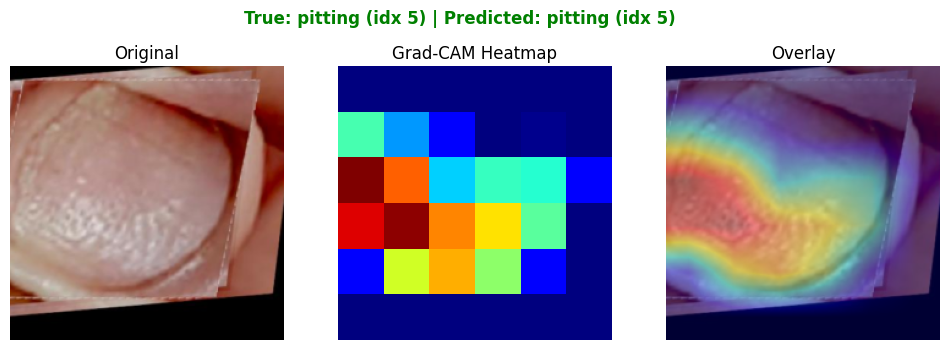

In [22]:
# Pick one batch from validation
# Create reverse mapping from index to class name
idx_to_class = {v: k for k, v in class_to_idx.items()}

val_batch = next(iter(dataloaders['validation']))
val_images, val_labels = val_batch

# Use first image
single_image = val_images[0].unsqueeze(0)  # (1,3,224,224)
heatmap, pred_class = generate_gradcam(model, single_image, device)

# Get true label
true_class = val_labels[0].item()

# Get class names
true_class_name = idx_to_class[true_class]
pred_class_name = idx_to_class[pred_class]

# To visualize properly, denormalize image
mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
denorm_image = val_images[0]*std + mean

orig, colored, overlay = overlay_heatmap_on_image(heatmap, denorm_image)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title('Original'); plt.imshow(orig); plt.axis('off')
plt.subplot(1,3,2); plt.title('Grad-CAM Heatmap'); plt.imshow(heatmap, cmap='jet'); plt.axis('off')
plt.subplot(1,3,3); plt.title('Overlay'); plt.imshow(overlay); plt.axis('off')

# Color code: green if correct, red if incorrect
color = 'green' if pred_class == true_class else 'red'
plt.suptitle(f'True: {true_class_name} (idx {true_class}) | Predicted: {pred_class_name} (idx {pred_class})', 
             color=color, fontweight='bold')
plt.show()

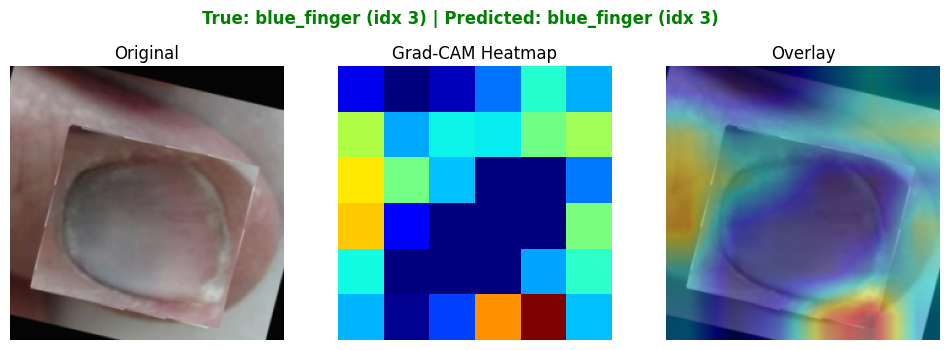

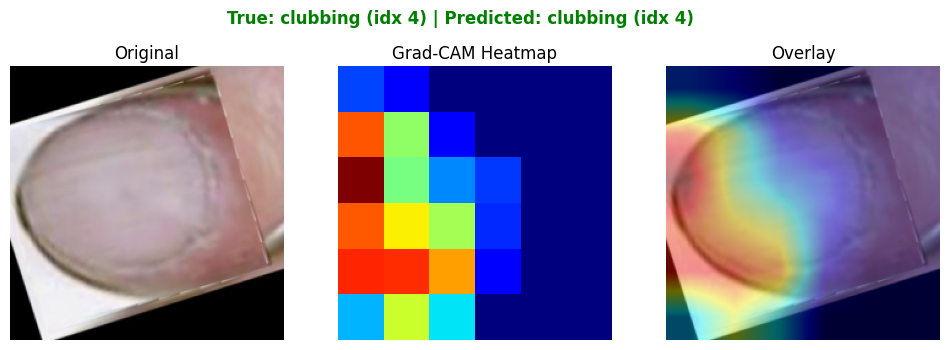

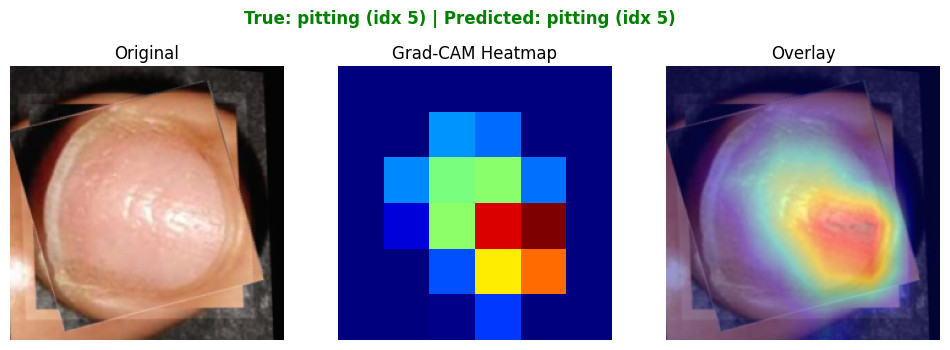

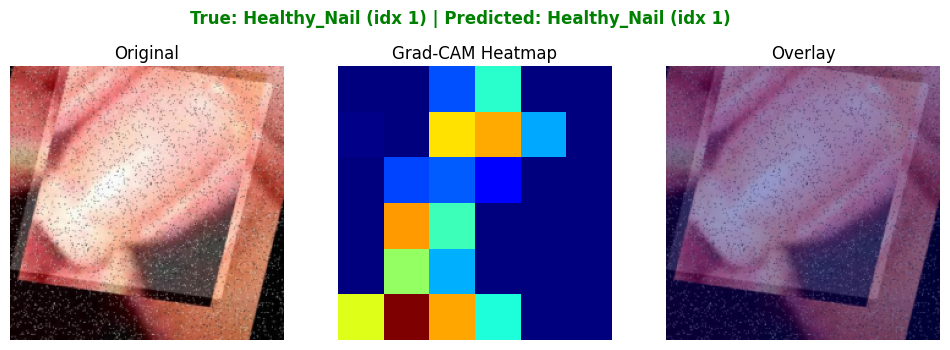

In [21]:
# Show grad-CAM visualization for multiple validation images
# Create reverse mapping from index to class name
idx_to_class = {v: k for k, v in class_to_idx.items()}

num_images = 4
val_batch = next(iter(dataloaders['validation']))
val_images, val_labels = val_batch

for i in range(num_images):
    single_image = val_images[i].unsqueeze(0)  # (1,3,224,224)
    heatmap, pred_class = generate_gradcam(model, single_image, device)
    
    # Get true label
    true_class = val_labels[i].item()
    
    # Get class names
    true_class_name = idx_to_class[true_class]
    pred_class_name = idx_to_class[pred_class]
    
    # To visualize properly, denormalize image
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    denorm_image = val_images[i]*std + mean

    orig, colored, overlay = overlay_heatmap_on_image(heatmap, denorm_image)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title('Original'); plt.imshow(orig); plt.axis('off')
    plt.subplot(1,3,2); plt.title('Grad-CAM Heatmap'); plt.imshow(heatmap, cmap='jet'); plt.axis('off')
    plt.subplot(1,3,3); plt.title('Overlay'); plt.imshow(overlay); plt.axis('off')
    
    # Color code: green if correct, red if incorrect
    color = 'green' if pred_class == true_class else 'red'
    plt.suptitle(f'True: {true_class_name} (idx {true_class}) | Predicted: {pred_class_name} (idx {pred_class})', 
                 color=color, fontweight='bold')
    plt.show()